In [16]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

In [17]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [18]:
def test_normality(data):
    stat, p = kstest(data, "norm")
    print("stat = ", stat)
    print("p = ", p)
    if p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")

In [19]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append([data[i + look_back]])
    return np.array(data_x), np.array(data_y)

In [20]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data = ether_data.interpolate()

In [21]:
ether_data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-03-10,11.20,11.85,11.07,11.75,0.0,0.0491
2016-03-11,11.75,11.95,11.75,11.95,180.0,0.0170
2016-03-12,11.95,13.45,11.95,12.92,830.0,0.0812
2016-03-13,12.92,15.07,12.92,15.07,1300.0,0.1664
2016-03-14,15.07,15.07,11.40,12.50,92180.0,-0.1705
...,...,...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46,899820.0,-0.0657
2022-05-06,2747.60,2757.14,2635.85,2692.88,881180.0,-0.0199
2022-05-07,2692.92,2703.11,2589.29,2636.03,458050.0,-0.0211


In [22]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2252 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [23]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.252000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.323084e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.037117e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.480000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.942500e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


In [24]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104588,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104855,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106389,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105243,0.000184
Volume,0.104588,0.104855,0.106389,0.105243,1.000000,0.000230
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000230,1.000000


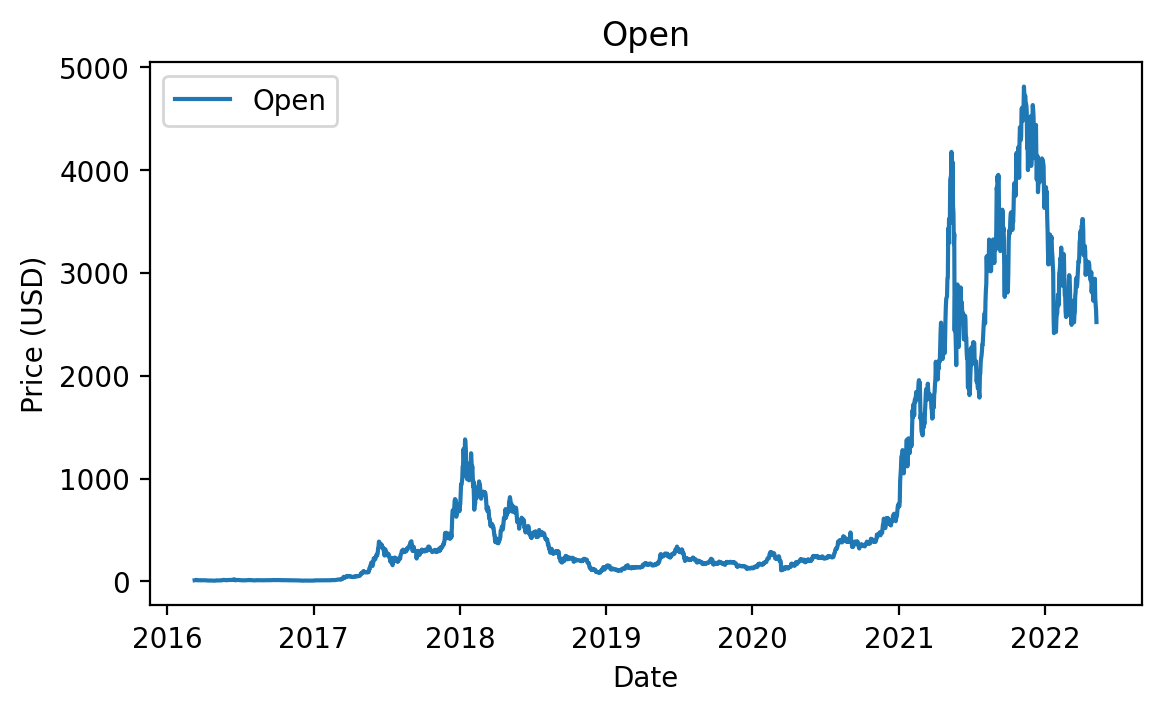

In [25]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["Open"], label="Open")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Open")
plt.show()

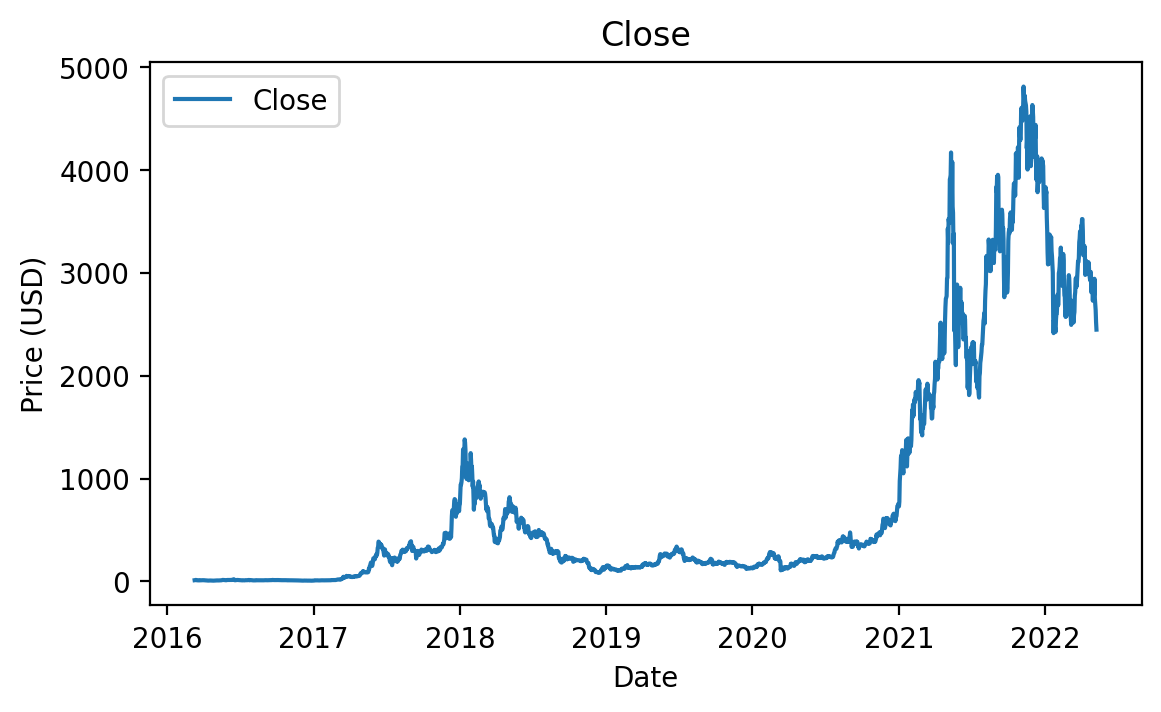

In [26]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["Close"], label="Close")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Close")
plt.show()

In [27]:
selected_features = ["Open"]
lookback_period = 5
dates = list(ether_data.index)
ether_data_lstm = pd.DataFrame(ether_data, columns=selected_features)

In [28]:
ether_data_lstm

,Open
Date,
2016-03-10,11.20
2016-03-11,11.75
2016-03-12,11.95
2016-03-13,12.92
2016-03-14,15.07
...,...
2022-05-05,2940.70
2022-05-06,2747.60
2022-05-07,2692.92


In [29]:
ether_data_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


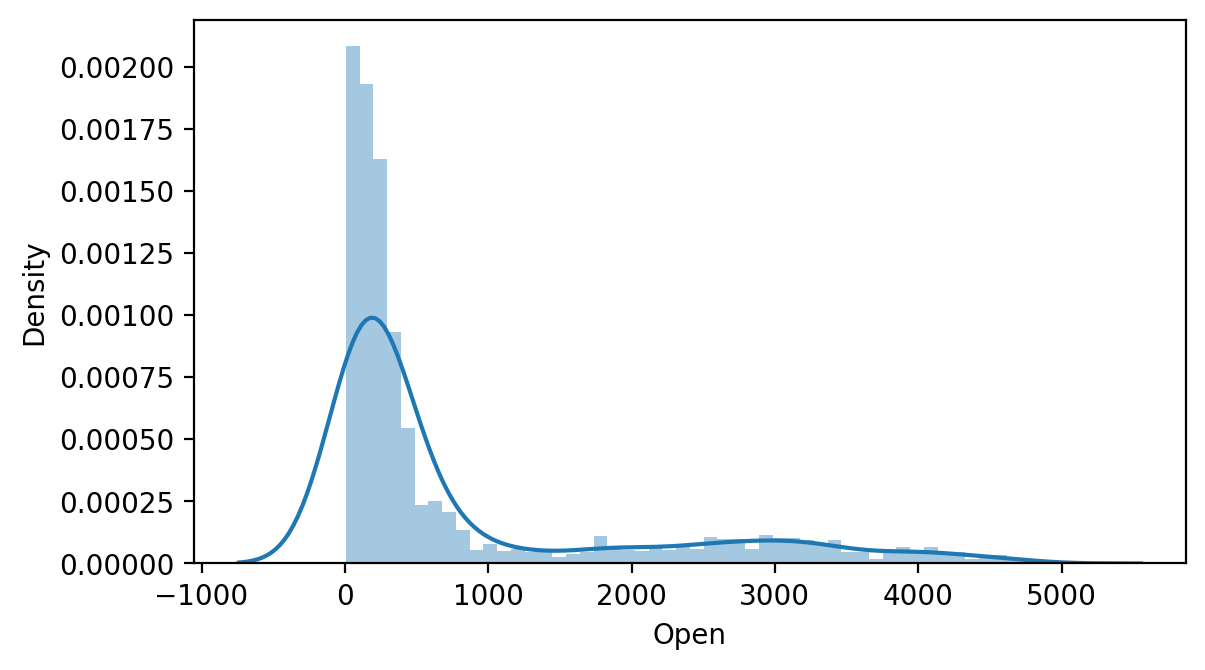

stat =  0.9999999999880529
p =  0.0
Not Gausssian.


In [30]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.distplot(ether_data["Open"])
plt.show()
test_normality(ether_data["Open"])

In [31]:
training_size = int(len(ether_data_lstm) * 0.80)
test_size = len(ether_data_lstm) - training_size
train_ether_data = ether_data_lstm[:training_size]
test_ether_data = ether_data_lstm[training_size:]

In [32]:
train_ether_data

,Open
Date,
2016-03-10,11.20
2016-03-11,11.75
2016-03-12,11.95
2016-03-13,12.92
2016-03-14,15.07
...,...
2021-02-08,1612.98
2021-02-09,1750.19
2021-02-10,1770.81


In [33]:
test_ether_data

,Open
Date,
2021-02-13,1840.90
2021-02-14,1815.44
2021-02-15,1800.60
2021-02-16,1778.63
2021-02-17,1781.44
...,...
2022-05-05,2940.70
2022-05-06,2747.60
2022-05-07,2692.92


In [34]:
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_ether_data)
scaled_test = standard_scaler.fit_transform(test_ether_data)

In [35]:
scaled_train.shape

(1801, 1)

In [36]:
scaled_test.shape

(451, 1)

In [37]:
lstm_train_x, lstm_train_y = prepare_for_lstm(scaled_train, 3)
lstm_test_x, lstm_test_y = prepare_for_lstm(scaled_test, 3)
lstm_train_x = lstm_train_x.reshape((-1, lstm_train_x.shape[1], 1))
lstm_test_x = lstm_test_x.reshape((-1, lstm_test_x.shape[1], 1))

In [38]:
lstm_train_x.shape, lstm_train_y.shape

((1798, 3, 1), (1798, 1, 1))

In [39]:
lstm_test_x.shape, lstm_test_y.shape

((448, 3, 1), (448, 1, 1))

In [40]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.LSTM(units=64, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
training_result = lstm_model.fit(lstm_train_x, lstm_train_y, batch_size=256, epochs=100, verbose=1, shuffle=False, validation_data=(lstm_test_x, lstm_test_y), callbacks=None)

Epoch 1/100
8/8 [==============================] - 4s 97ms/step - loss: 0.9809 - val_loss: 0.8684
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.8493 - val_loss: 0.7458
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.7297 - val_loss: 0.5921
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.5720 - val_loss: 0.4013
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.3759 - val_loss: 0.2169
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1891 - val_loss: 0.1303
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0634 - val_loss: 0.0717
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0383 - val_loss: 0.0933
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0547 - val_loss: 0.0905
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0339 - val_loss: 0.0650
Epoch 11/100
8/8 [=

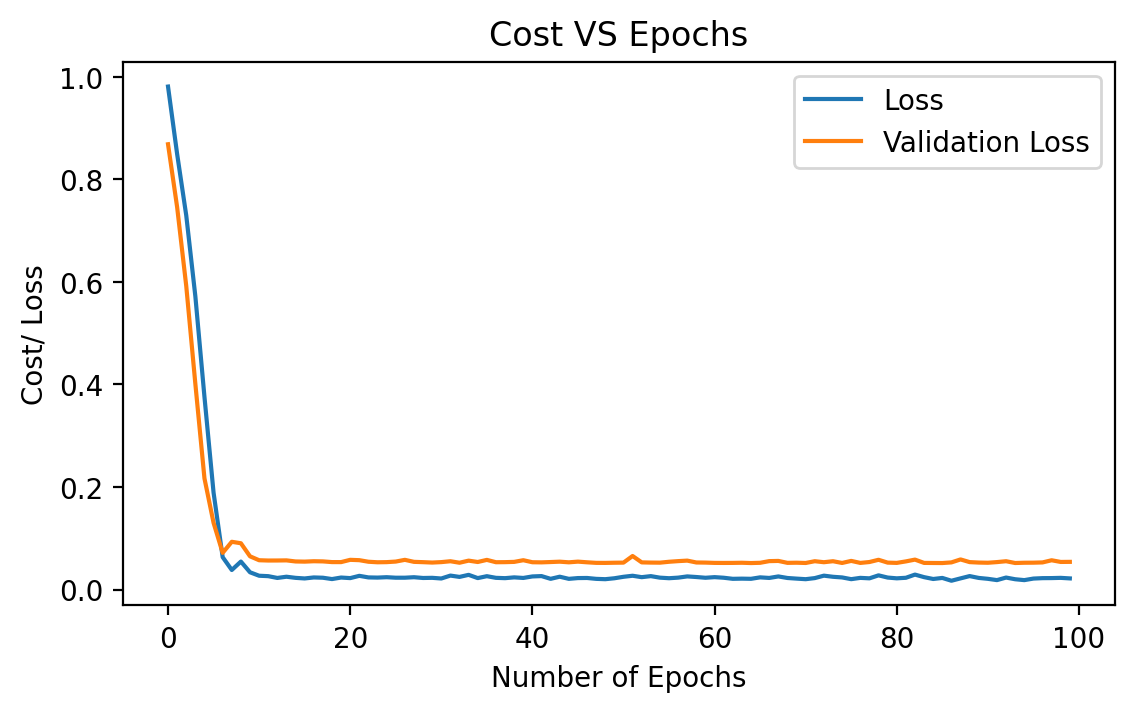

In [42]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(training_result.history["loss"], label="Loss")
plt.plot(training_result.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Cost/ Loss")
plt.title("Cost VS Epochs")
plt.show()

In [43]:
actual_ether_data = standard_scaler.inverse_transform(lstm_test_y.reshape(-1, lstm_test_y.shape[1]))
predicted_ether_data = standard_scaler.inverse_transform(lstm_model.predict(lstm_test_x))

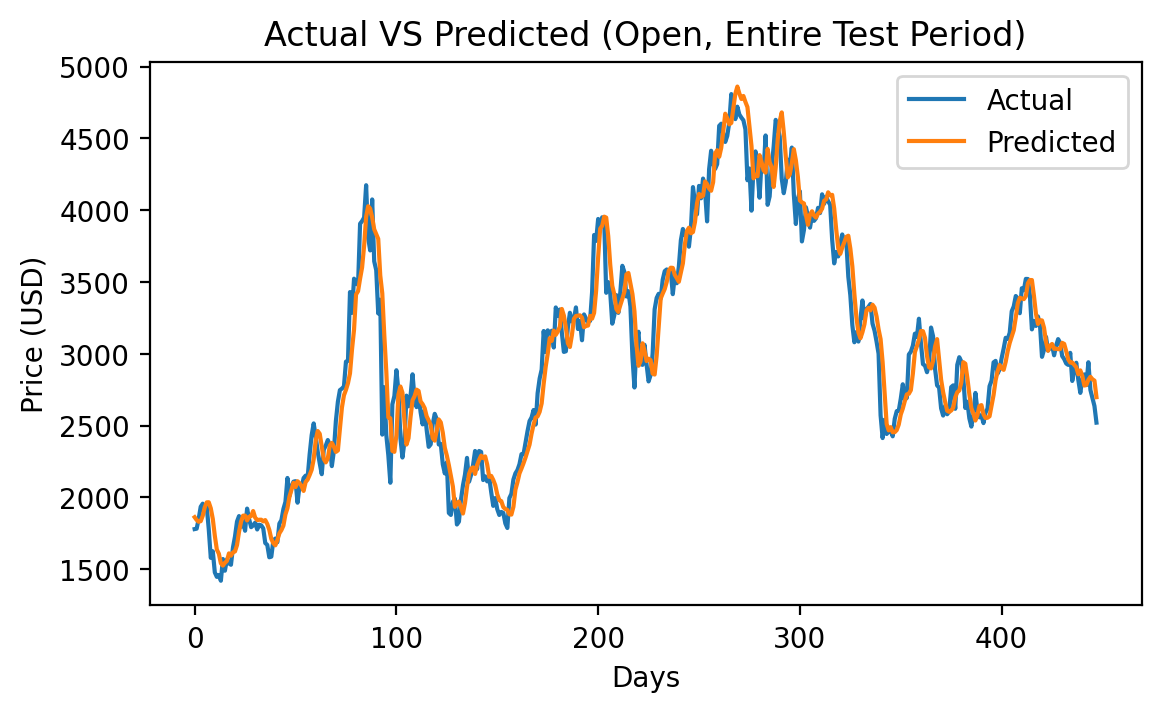

In [52]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:, 0], label="Actual")
plt.plot(predicted_ether_data[:, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, Entire Test Period)")
plt.show()

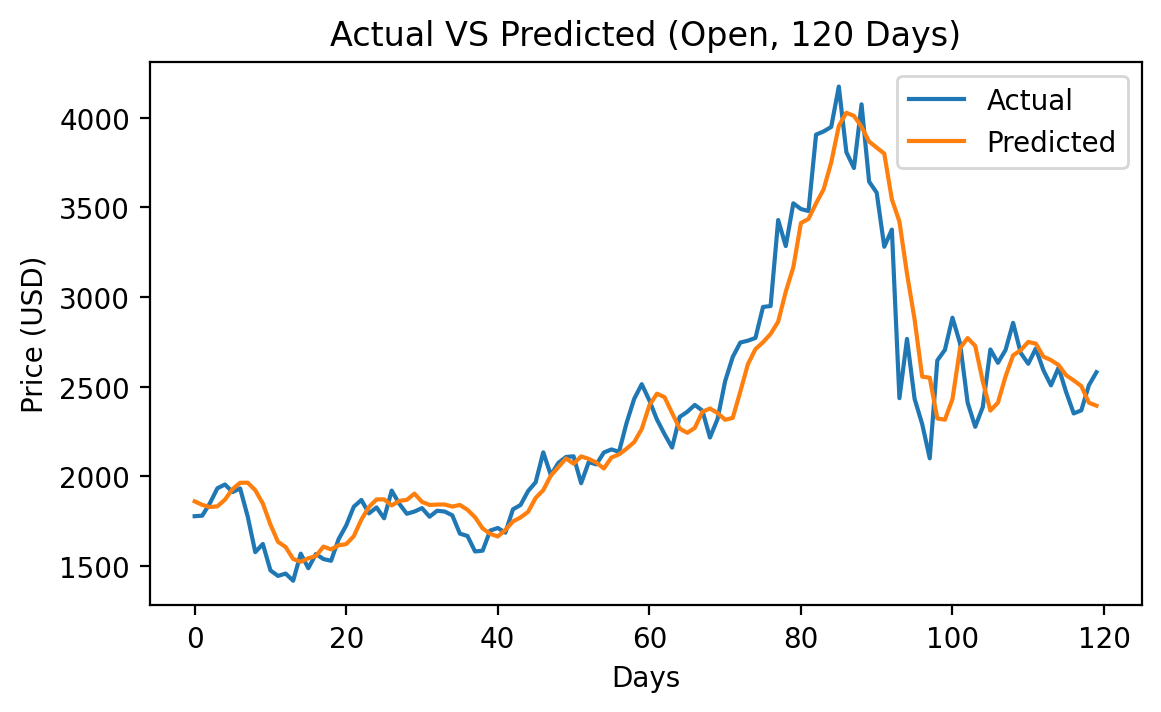

In [45]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:120, 0], label="Actual")
plt.plot(predicted_ether_data[:120, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 120 Days)")
plt.show()

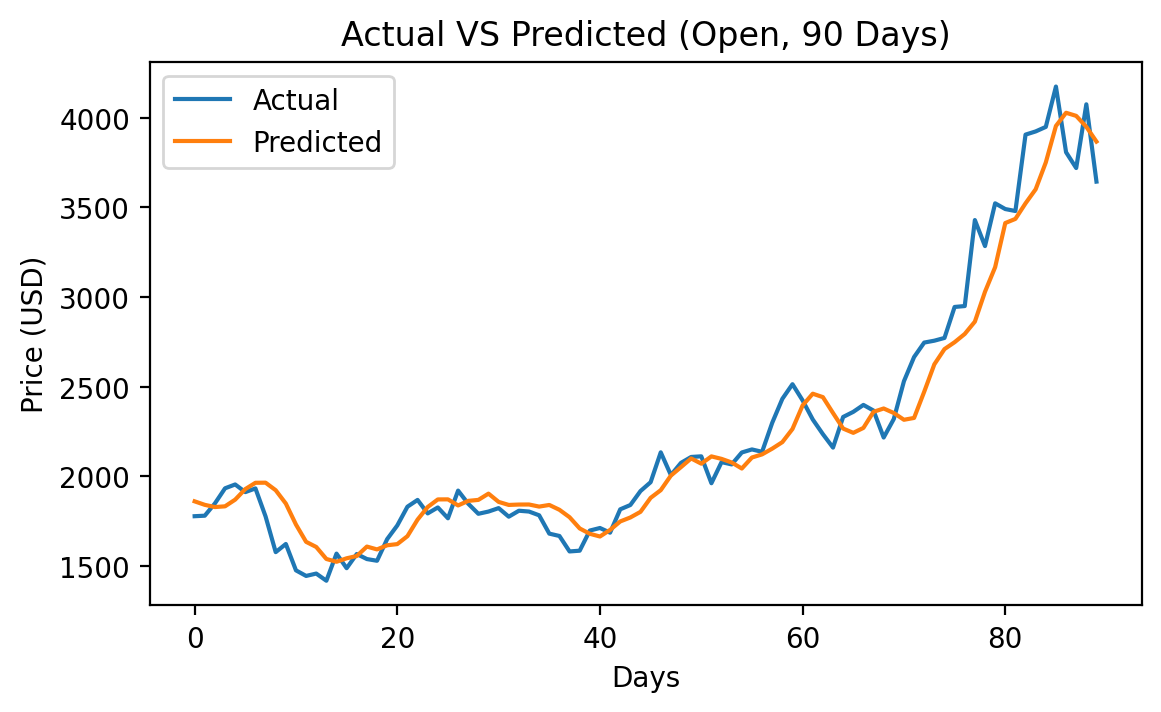

In [46]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:90, 0], label="Actual")
plt.plot(predicted_ether_data[:90, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 90 Days)")
plt.show()

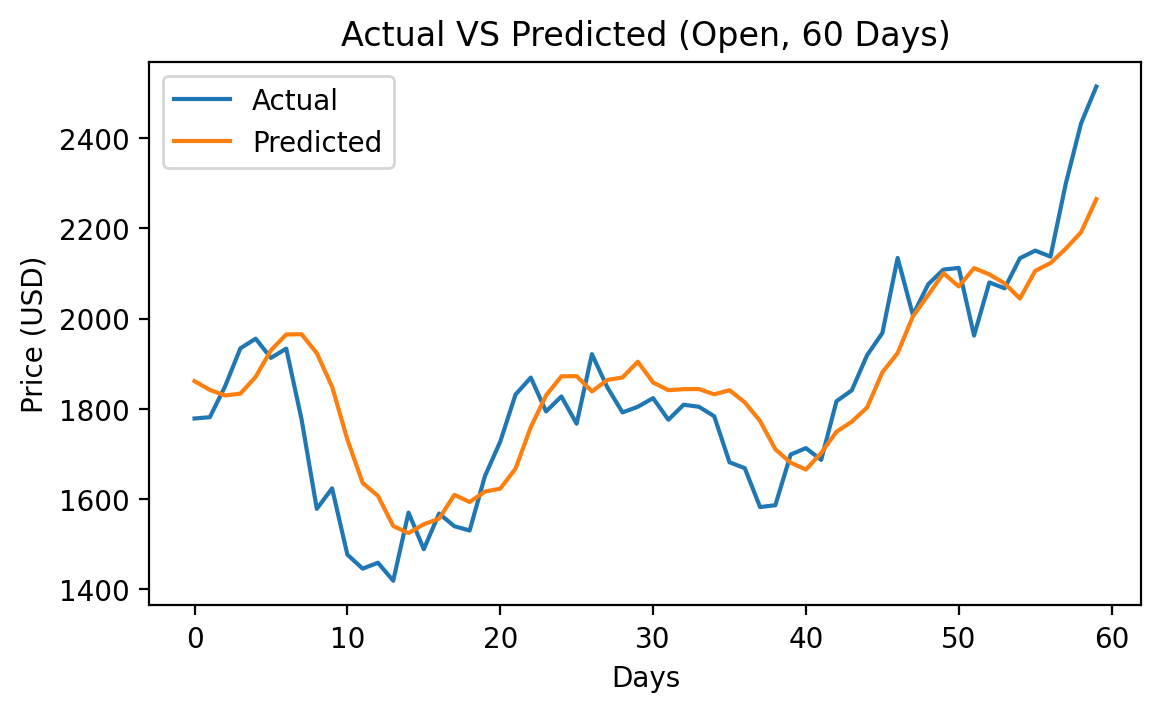

In [47]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:60, 0], label="Actual")
plt.plot(predicted_ether_data[:60, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 60 Days)")
plt.show()

In [48]:
print("Performance:")
mse = mean_squared_error(actual_ether_data[:, 0], predicted_ether_data[:, 0])
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual_ether_data[:, 0], predicted_ether_data[:, 0])
mape = mean_absolute_percentage_error(actual_ether_data[:, 0], predicted_ether_data[:, 0]) * 100
print("mean squared error: ", mse)
print("root mean square error: ", rmse)
print("mean absolute error: ", mae)
print("mean absolute percentage error: ", mape, "%")

Performance:
mean squared error:  35066.57446569687
root mean square error:  187.26071255257165
mean absolute error:  142.05300432477677
mean absolute percentage error:  4.99488688045023 %
